<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br><br><br>

# Listed Volatility and Variance Derivatives

**Dr. Yves J. Hilpisch &mdash; Wiley Finance (2016)**

<img src="http://hilpisch.com/images/lvvd_cover.png" alt="Derivatives Analytics with Python" width="30%" align="left" border="0">

# DX Analytics &mdash; An Overview

## Introduction

You need to install DX Analytics. See http://dx-analytics.com.

## Modeling Risk Factors

In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import dx
import numpy as np
np.random.seed(1000)
import pandas as pd
import datetime as dt
import seaborn as sns; sns.set()
import matplotlib as mpl; 
%matplotlib inline

In [3]:
r = dx.constant_short_rate('r', 0.01)

In [4]:
## instantiation of market environment object
me_1 = dx.market_environment('me', dt.datetime(2016, 1, 1))
## starting value of simulated processes
me_1.add_constant('initial_value', 100.)
## volatiltiy factor
me_1.add_constant('volatility', 0.2)
## horizon for simulation
me_1.add_constant('final_date', dt.datetime(2016, 6, 30))
## currency of instrument
me_1.add_constant('currency', 'EUR')
## frequency for discretization (here: weekly)
me_1.add_constant('frequency', 'W')
## number of paths
me_1.add_constant('paths', 25000)
## short rate model for discount curve
me_1.add_curve('discount_curve', r)

In [5]:
gbm_1 = dx.geometric_brownian_motion('gbm_1', me_1)
gbm_1

In [6]:
gbm_1.get_instrument_values()

array([[ 100.        ,  100.        ,  100.        , ...,  100.        ,
         100.        ,  100.        ],
       [ 103.99970675,  100.94138063,  101.87289049, ...,  101.57080458,
         100.82390334,   98.15531921],
       [ 101.93603717,   94.66240389,   91.81649108, ...,  101.20745936,
          99.98530091,  102.49930045],
       ..., 
       [  94.34847745,  111.87828236,  105.88943893, ...,   89.84492969,
         109.03063645,  107.8625328 ],
       [  91.01721535,  113.83465258,  102.59432299, ...,   92.09515398,
         104.17599152,  101.67756176],
       [  90.56511589,  113.20730366,  100.79160449, ...,   90.91965416,
         100.6385713 ,  101.76583508]])

In [7]:
gbm_1.time_grid[:10]

array([datetime.datetime(2016, 1, 1, 0, 0),
       datetime.datetime(2016, 1, 3, 0, 0),
       datetime.datetime(2016, 1, 10, 0, 0),
       datetime.datetime(2016, 1, 17, 0, 0),
       datetime.datetime(2016, 1, 24, 0, 0),
       datetime.datetime(2016, 1, 31, 0, 0),
       datetime.datetime(2016, 2, 7, 0, 0),
       datetime.datetime(2016, 2, 14, 0, 0),
       datetime.datetime(2016, 2, 21, 0, 0),
       datetime.datetime(2016, 2, 28, 0, 0)], dtype=object)

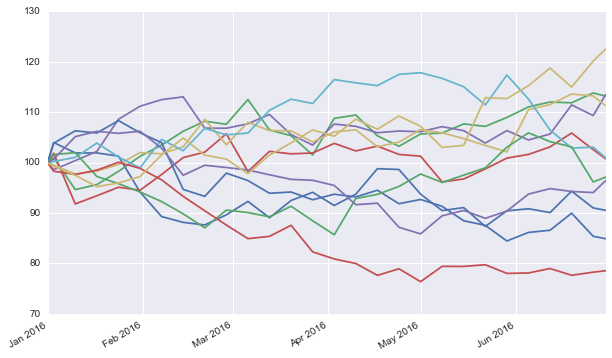

In [8]:
pdf_1 = pd.DataFrame(gbm_1.get_instrument_values(), index=gbm_1.time_grid)
pdf_1.ix[:, :10].plot(legend=False, figsize=(10, 6));

In [9]:
## instantiate new market environment object
me_2 = dx.market_environment('me_2', me_1.pricing_date)
## add complete environment
me_2.add_environment(me_1)
## overwrite volatility value
me_2.add_constant('volatility', 0.5)

In [10]:
gbm_2 = dx.geometric_brownian_motion('gbm_2', me_2)

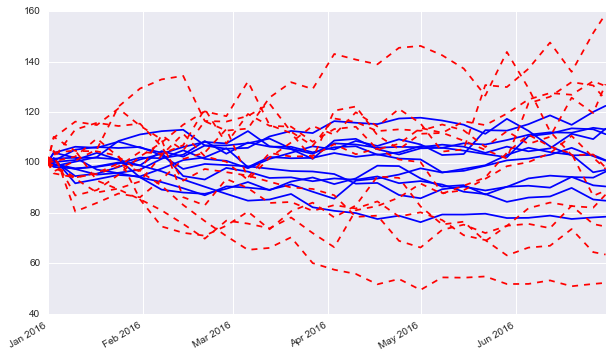

In [11]:
pdf_2 = pd.DataFrame(gbm_2.get_instrument_values(), index=gbm_2.time_grid)
ax = pdf_1.ix[:, :10].plot(legend=False, figsize=(10, 6), style=11 * ['b-']);
pdf_2.ix[:, :10].plot(legend=False, style=11 * ['r--'], ax=ax);

## Modeling Derivatives

In [12]:
## instantiation of market environment object for option
me_opt = dx.market_environment('me_opt', me_1.pricing_date)
## add complete market environment
me_opt.add_environment(me_1)
## add maturity date for option
me_opt.add_constant('maturity', dt.datetime(2016, 6, 30))
## add strike for option
me_opt.add_constant('strike', 110.)

In [13]:
am_put = dx.valuation_mcs_american_single(
            name='am_put',  # name of the option as string
            underlying=gbm_1,  # the risk factor object
            mar_env=me_opt,  # the market environment
            payoff_func='np.maximum(strike - instrument_values, 0)')

In [14]:
am_put.present_value()  # Monte Carlo estimator

11.799

In [15]:
am_put.delta()  # delta of the option

-0.6809

In [16]:
am_put.gamma()  # gamma of the option

0.0149

In [17]:
0.5 * am_put.gamma() * am_put.underlying.initial_value ** 2  # dollar gamma

74.5

In [18]:
am_put.vega()  # vega of the option

23.8208

In [19]:
am_put.theta()  # theta of the option 

-3.81

In [20]:
am_put.rho()  # rho of the option

-30.113

In [21]:
eur_call = dx.valuation_mcs_european_single(
            name='eur_call',
            underlying=gbm_2,
            mar_env=me_opt,
            payoff_func='np.maximum(maturity_value - strike, 0)')

In [22]:
eur_call.present_value()

10.364663

In [23]:
eur_call.delta()

0.4174

In [24]:
eur_call.gamma()

0.0121

In [25]:
0.5 * eur_call.gamma() * eur_call.underlying.initial_value ** 2

60.5

In [26]:
eur_call.vega()

27.6147

In [27]:
eur_call.theta()

-14.1996

In [28]:
eur_call.rho()

18.0684

In [29]:
k_list = np.arange(80., 120.5, 2.5)
pv = []; de = []; ve = []; th = []; rh = []; ga = []
for k in k_list:
    eur_call.update(strike=k)
    pv.append(eur_call.present_value())
    de.append(eur_call.delta())
    ve.append(eur_call.vega())
    th.append(eur_call.theta())
    rh.append(eur_call.rho())
    ga.append(eur_call.gamma())

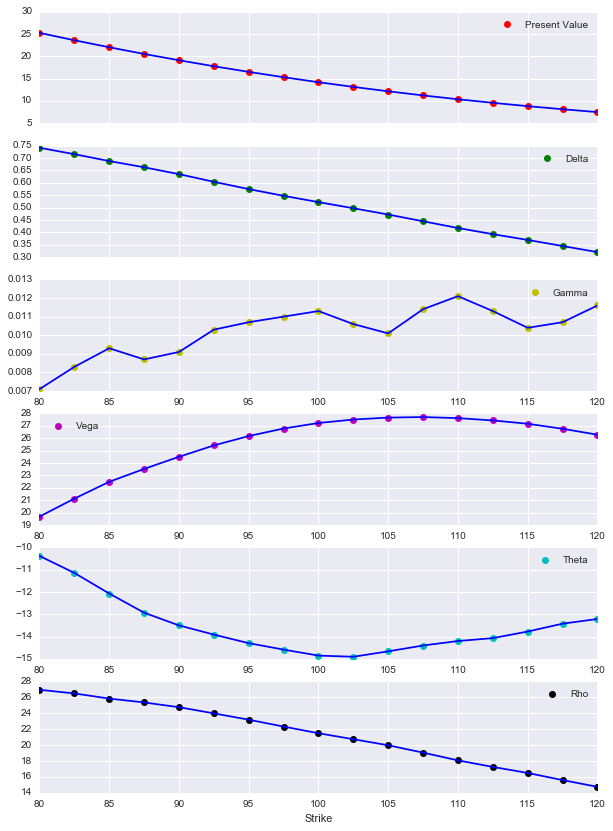

In [30]:
dx.plot_option_stats_full(k_list, pv, de, ga, ve, th, rh)

## Derivatives Portfolios

### Modeling Portfolios

In [31]:
me_1.add_constant('model', 'gbm')
me_2.add_constant('model', 'gbm')

In [32]:
put = dx.derivatives_position(
    name='put',  # name as string
    quantity=2,  # number of options in the portfolio
    underlyings=['gbm_1'],  # the underlying(s) as list object
    mar_env=me_opt,  # the market environment object
    otype='American single',  # the option type
    payoff_func='np.maximum(strike - instrument_values, 0)')  # the payoff

call = dx.derivatives_position(
    name='call',
    quantity=3,
    underlyings=['gbm_2'],
    mar_env=me_opt,
    otype='European single',
    payoff_func='np.maximum(maturity_value - strike, 0)')

In [33]:
risk_factors = {'gbm_1': me_1, 'gbm_2' : me_2}  # as dictionary
correlations = [['gbm_1', 'gbm_2', -0.4]]  # as list
positions = {'put' : put, 'call' : call}  # as dictionary

In [34]:
val_env = dx.market_environment('general', dt.datetime(2016, 1, 1))
val_env.add_constant('frequency', 'W')
val_env.add_constant('paths', 25000)
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', val_env.pricing_date)
val_env.add_curve('discount_curve', r)

In [35]:
port = dx.derivatives_portfolio(
        name='portfolio',  # name as string
        positions=positions,  # derivatives positions
        val_env=val_env,  # valuation environment
        risk_factors=risk_factors, # relevant risk factors
        correlations=correlations,  # correlation between risk factors
        parallel=False)  # parallel valuation True/False

### Simulation and Valuation

In [36]:
port.get_values()  # get all present values

Total
pos_value    54.103966
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value
0,put,put,2,American single,[gbm_1],11.804000,EUR,23.608000
1,call,call,3,European single,[gbm_2],10.165322,EUR,30.495966


In [37]:
port.get_statistics()  # get major statistics

Totals
pos_value     54.1030
pos_delta      0.0082
pos_vega     130.9992
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
0,put,put,2,American single,[gbm_1],11.804,EUR,23.608,-1.4192,48.7344
1,call,call,3,European single,[gbm_2],10.165,EUR,30.495,1.4274,82.2648


### Risk Reports

In [38]:
deltas, benchvalue = port.get_port_risk(Greek='Delta')


gbm_1
0.8 0.9 1.0 1.1 1.2 
gbm_2
0.8 0.9 1.0 1.1 1.2 




In [39]:
benchvalue

54.103966

In [40]:
deltas

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 5 (major_axis) x 2 (minor_axis)
Items axis: gbm_1_Delta to gbm_2_Delta
Major_axis axis: 0.8 to 1.2
Minor_axis axis: factor to value

In [41]:
dx.risk_report(deltas)  # gives the resulting values ...


gbm_1_Delta
          0.8    0.9    1.0     1.1     1.2
factor  80.00  90.00  100.0  110.00  120.00
value   90.51  70.89   54.1   42.19   35.37

gbm_2_Delta
          0.8    0.9    1.0     1.1     1.2
factor  80.00  90.00  100.0  110.00  120.00
value   33.28  41.94   54.1   69.74   88.39


In [42]:
dx.risk_report(deltas.ix[:, :, 'value'] - benchvalue,
               gross=False)  # ... as net changes

     gbm_1_Delta  gbm_2_Delta
0.8        36.41       -20.83
0.9        16.79       -12.16
1.0         0.00         0.00
1.1       -11.92        15.63
1.2       -18.74        34.28


In [43]:
vegas, benchvalue = port.get_port_risk(Greek='Vega', step=0.05)


gbm_1
0.8 0.85 0.9 0.95 1.0 1.05 1.1 1.15 1.2 
gbm_2
0.8 0.85 0.9 0.95 1.0 1.05 1.1 1.15 1.2 




In [44]:
dx.risk_report(vegas)


gbm_1_Vega
         0.80   0.85   0.90   0.95  1.00   1.05   1.10   1.15   1.20
factor   0.16   0.17   0.18   0.19   0.2   0.21   0.22   0.23   0.24
value   52.40  52.85  53.20  53.64  54.1  54.59  55.05  55.52  56.01

gbm_2_Vega
         0.80   0.85   0.90   0.95  1.00   1.05   1.10   1.15   1.20
factor   0.40   0.43   0.45   0.48   0.5   0.53   0.55   0.58   0.60
value   45.92  47.95  50.00  52.05  54.1  56.16  58.22  60.28  62.34


In [45]:
dx.risk_report(vegas.ix[:, :, 'value'] - benchvalue, gross=False)

      gbm_1_Vega  gbm_2_Vega
0.80       -1.70       -8.19
0.85       -1.26       -6.15
0.90       -0.91       -4.11
0.95       -0.47       -2.05
1.00        0.00        0.00
1.05        0.49        2.06
1.10        0.95        4.12
1.15        1.41        6.18
1.20        1.90        8.24


## Conclusions

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

**DX Analytics** |
<a href="http://dx-analytics.com">http://dx-analytics.com</a>

**Quant Platform** |
<a href="http://quant-platform.com">http://quant-platform.com</a>

**Python for Finance Books** |
<a href="http://books.tpq.io" target="_blank">http://books.tpq.io</a>

**Python for Finance Training** |
<a href="http://training.tpq.io" target="_blank">http://training.tpq.io</a>